In [48]:
import pandas as pd
import numpy as np
import os
import plotly.offline as py
py.init_notebook_mode(connected=False)
import plotly.graph_objs as go
import json
import cufflinks as cf
import seaborn as sns
cf.set_config_file(offline=True)
import json
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import requests

In [49]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [84]:
PJME_hourly = pd.read_csv('PJME_hourly.csv', parse_dates=[0], index_col=[0])

In [85]:
color_palette = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

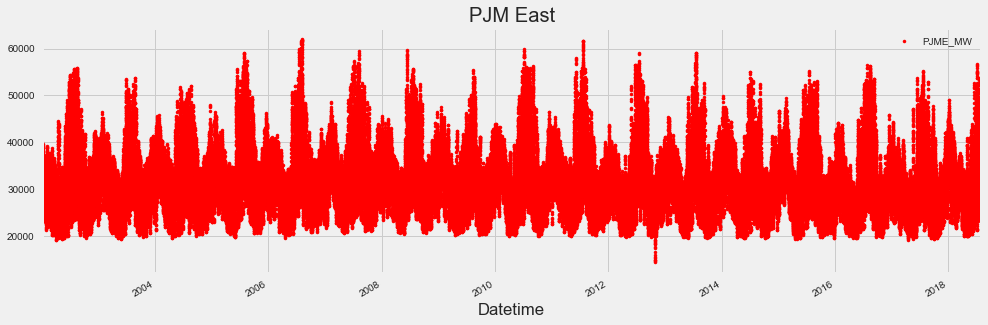

In [86]:
PJME_hourly.plot(style='.', figsize=(15,5), title='PJM East', color = 'red')

#### Train / Test Split

In [53]:
date_split = '01-Jan-2016'
PJME_hourly_train = PJME_hourly.loc[PJME_hourly.index <= date_split].copy()
PJME_hourly_test = PJME_hourly.loc[PJME_hourly.index > date_split].copy()

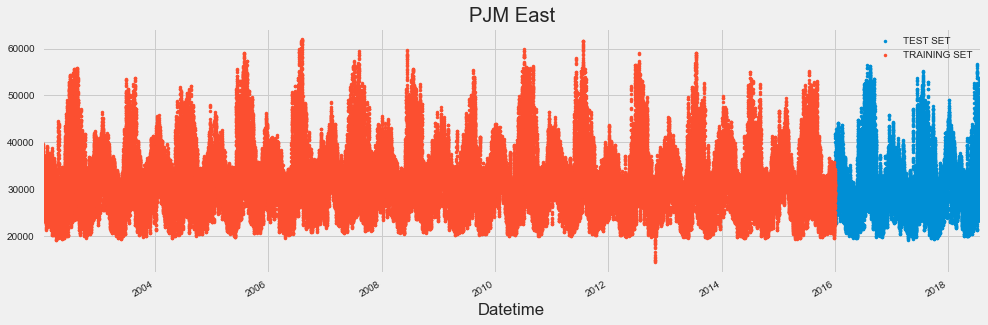

In [54]:
PJM_East = PJME_hourly_test \
            .rename(columns={'PJME_MW':'TEST SET'}) \
            .join(PJME_hourly_train.rename(columns={'PJME_MW':'TRAINING SET'}), how='outer') \
            .plot(figsize=(15,5), title='PJM East', style='.')

#### Time Series Features

In [55]:
def time_series_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [56]:
X_train, y_train = time_series_features(PJME_hourly_train, label='PJME_MW')
X_test, y_test = time_series_features(PJME_hourly_test, label='PJME_MW')

#### XGBoost Model

In [57]:
xgb_regressor = xgb.XGBRegressor(n_estimators=2000)

In [58]:
xgb_regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=500,
                 verbose=True) # Change verbose to False if you don't want to see it train

[0]	validation_0-rmse:23166.02344	validation_1-rmse:22123.00977
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:16404.47656	validation_1-rmse:15399.68848
[2]	validation_0-rmse:11735.73144	validation_1-rmse:10906.88965
[3]	validation_0-rmse:8537.43848	validation_1-rmse:7941.07617
[4]	validation_0-rmse:6407.28516	validation_1-rmse:5991.84473
[5]	validation_0-rmse:5008.22314	validation_1-rmse:4828.50244
[6]	validation_0-rmse:4118.14697	validation_1-rmse:4330.88818
[7]	validation_0-rmse:3600.19629	validation_1-rmse:4068.31055
[8]	validation_0-rmse:3295.75269	validation_1-rmse:3946.78784
[9]	validation_0-rmse:3130.13184	validation_1-rmse:3917.34424
[10]	validation_0-rmse:2981.52783	validation_1-rmse:3936.00293
[11]	validation_0-rmse:2904.97803	validation_1-rmse:3927.49561
[12]	validation_0-rmse:2836.91211	validation_1-rmse:4001.06323
[13]	validation_0-rmse:27

[128]	validation_0-rmse:1590.89356	validation_1-rmse:4551.85742
[129]	validation_0-rmse:1586.61902	validation_1-rmse:4552.11572
[130]	validation_0-rmse:1583.06421	validation_1-rmse:4551.28223
[131]	validation_0-rmse:1575.91528	validation_1-rmse:4551.50049
[132]	validation_0-rmse:1571.95081	validation_1-rmse:4553.90039
[133]	validation_0-rmse:1565.14844	validation_1-rmse:4551.26172
[134]	validation_0-rmse:1562.22253	validation_1-rmse:4553.56738
[135]	validation_0-rmse:1554.63989	validation_1-rmse:4557.90772
[136]	validation_0-rmse:1551.48267	validation_1-rmse:4555.38184
[137]	validation_0-rmse:1550.58887	validation_1-rmse:4555.84961
[138]	validation_0-rmse:1550.16211	validation_1-rmse:4555.27978
[139]	validation_0-rmse:1548.78748	validation_1-rmse:4554.88672
[140]	validation_0-rmse:1543.35132	validation_1-rmse:4558.19385
[141]	validation_0-rmse:1533.87415	validation_1-rmse:4557.35498
[142]	validation_0-rmse:1530.37866	validation_1-rmse:4557.63281
[143]	validation_0-rmse:1526.82117	valid

[257]	validation_0-rmse:1187.00915	validation_1-rmse:4724.36475
[258]	validation_0-rmse:1185.44165	validation_1-rmse:4724.20703
[259]	validation_0-rmse:1182.19495	validation_1-rmse:4723.24268
[260]	validation_0-rmse:1180.56470	validation_1-rmse:4723.82715
[261]	validation_0-rmse:1179.39050	validation_1-rmse:4724.74658
[262]	validation_0-rmse:1176.34387	validation_1-rmse:4725.27295
[263]	validation_0-rmse:1174.38440	validation_1-rmse:4725.12451
[264]	validation_0-rmse:1173.06799	validation_1-rmse:4723.97607
[265]	validation_0-rmse:1172.53345	validation_1-rmse:4724.17529
[266]	validation_0-rmse:1169.02600	validation_1-rmse:4724.00391
[267]	validation_0-rmse:1166.94714	validation_1-rmse:4723.32422
[268]	validation_0-rmse:1163.67639	validation_1-rmse:4724.33545
[269]	validation_0-rmse:1161.80249	validation_1-rmse:4724.24365
[270]	validation_0-rmse:1159.86792	validation_1-rmse:4725.43506
[271]	validation_0-rmse:1157.36499	validation_1-rmse:4725.41016
[272]	validation_0-rmse:1154.32654	valid

[386]	validation_0-rmse:983.27307	validation_1-rmse:4767.29443
[387]	validation_0-rmse:981.34558	validation_1-rmse:4766.79980
[388]	validation_0-rmse:979.33063	validation_1-rmse:4766.79199
[389]	validation_0-rmse:977.45642	validation_1-rmse:4767.07715
[390]	validation_0-rmse:976.62598	validation_1-rmse:4767.07471
[391]	validation_0-rmse:975.52374	validation_1-rmse:4766.55176
[392]	validation_0-rmse:974.82660	validation_1-rmse:4767.74219
[393]	validation_0-rmse:974.17346	validation_1-rmse:4768.94141
[394]	validation_0-rmse:973.84998	validation_1-rmse:4768.88330
[395]	validation_0-rmse:972.40649	validation_1-rmse:4767.76465
[396]	validation_0-rmse:970.92151	validation_1-rmse:4767.96289
[397]	validation_0-rmse:970.13471	validation_1-rmse:4767.99316
[398]	validation_0-rmse:969.58569	validation_1-rmse:4767.51562
[399]	validation_0-rmse:968.94836	validation_1-rmse:4768.14453
[400]	validation_0-rmse:968.62347	validation_1-rmse:4767.96582
[401]	validation_0-rmse:967.47809	validation_1-rmse:476

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

#### Feature importances

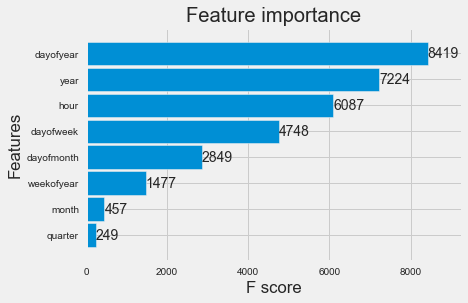

In [59]:
plot_importance(xgb_regressor, height=0.9)

#### Forecast on a test set

In [60]:
PJME_hourly_test['MW_Prediction'] = xgb_regressor.predict(X_test)
PJME_All = pd.concat([PJME_hourly_test, PJME_hourly_train], sort=False)

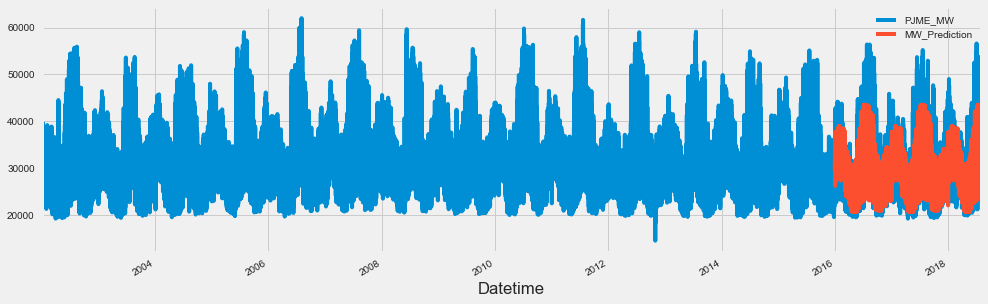

In [61]:
PJME_All[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

#### First month of forecast

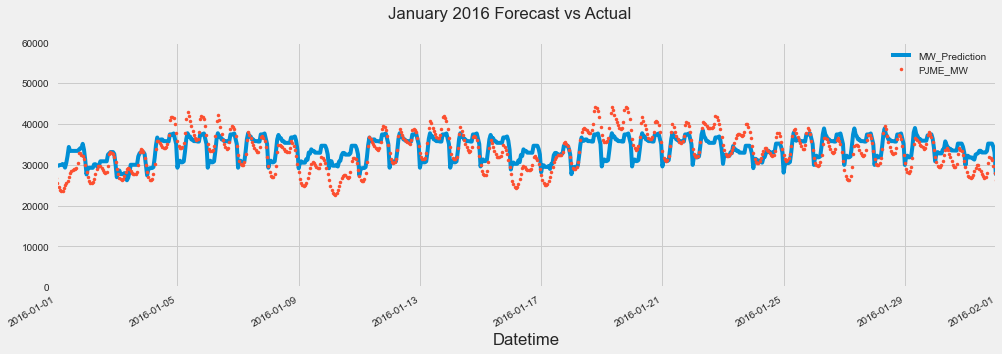

In [62]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
PJME_All[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2016', upper='02-01-2016')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2016 Forecast vs Actual')

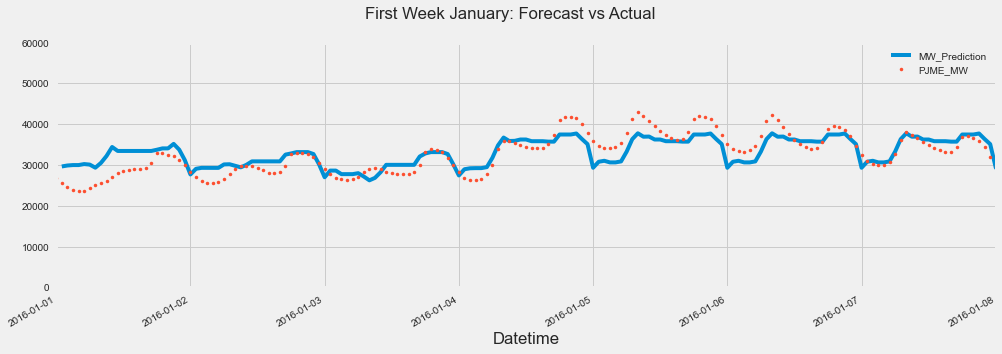

In [64]:
# first week
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
PJME_All[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2016', upper='01-08-2016')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week January: Forecast vs Actual')

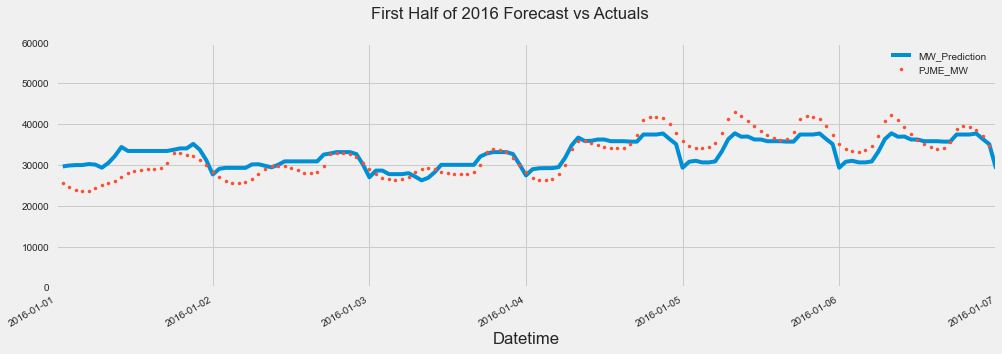

In [66]:
# first 6 months
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
PJME_All[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='01-01-2016', upper='01-07-2016')
plot = plt.suptitle('First Half of 2016 Forecast vs Actuals')

#### Error metrics

In [72]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [76]:
print("MSE:", mean_squared_error(y_true=PJME_hourly_test['PJME_MW'], y_pred=PJME_hourly_test['MW_Prediction']))
print("MAE:", mean_absolute_error(y_true=PJME_hourly_test['PJME_MW'], y_pred=PJME_hourly_test['MW_Prediction']))
print("MAPE:", mean_absolute_percentage_error(y_true=PJME_hourly_test['PJME_MW'], y_pred=PJME_hourly_test['MW_Prediction']), '%')

MSE: 15345595.89366416
MAE: 2916.7902240061017
MAPE: 9.099358478232707 %
